In [2]:
import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt
import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.tree import plot_tree

#### Источники данных

In [2]:
token_vk = "777"
id_sankt_pet = '-187956888'
id_auto = '-93614683'
id_moscow = '-137324015'
mas_id = [id_sankt_pet,id_auto,id_moscow]

#### Получение данных

In [4]:
from vk_api import VkApi
import vk_api

token = token_vk

def main(offset: int, token: str, group_id: str):
    vk = vk_api.VkApi(token=token) # авторизация через токен (желательно)
    api = vk.get_api()
    posts = api.wall.get(owner_id = group_id, offset = offset, count=100)['items']
    posts_strings = [post['text'] for post in posts]
    num_like = []
    comments_strings = []
    for post in posts:
        comments = api.wall.getComments(owner_id = group_id, post_id=post['id'], count=100)['items']
        comments_strings.append([comment['text'] for comment in comments])
        itemID = post['id']
        isLiked = api.likes.getList(
        type = 'post', 
        owner_id = group_id, 
        item_id = itemID               
        )
        num_like.
        append(isLiked['count'])
    return posts_strings, comments_strings, num_like


combo_list_posts = []
combolist_comments = []
combolist_like_count = []

for group_id in mas_id:
    for i in range(0, 301, 100):
        try:
            rzd_posts, comments_strings_rzd, rzd_like_count = main(offset = i, token = token, group_id = group_id)
            combo_list_posts.extend(rzd_posts)
            combolist_comments.extend(comments_strings_rzd)
            combolist_like_count.extend(rzd_like_count)
            print(group_id,i)
        except:
            print('Постов больше нет на смещении: ', i)


Постов больше нет на смещении:  0
Постов больше нет на смещении:  100
Постов больше нет на смещении:  200
Постов больше нет на смещении:  300
Постов больше нет на смещении:  0
Постов больше нет на смещении:  100
Постов больше нет на смещении:  200
Постов больше нет на смещении:  300
Постов больше нет на смещении:  0
Постов больше нет на смещении:  100
Постов больше нет на смещении:  200
Постов больше нет на смещении:  300


In [15]:
#категории постов
mas_category = ['транспорт санкт-перебурга' for i in range(400)]
mas_category.extend(['автомобильный' for i in range(400)])
mas_category.extend(['транспорт москвы' for i in range(400)])

In [22]:
#количество комментариев в каждом посту
combolist_comments_count = [len(comments) for comments in combolist_comments]

In [23]:
#датасет с данными
data = pd.DataFrame({'посты':combo_list_posts,'комментарии':combolist_comments_count,'лайки':combolist_like_count})

In [24]:
data

посты  комментарии  лайки
0     Уважаемые петербуржцы! \n \nВ официальной груп...            0    154
1     #усиление_маршрутов\n\n9 апреля, в Вербное вос...            7     30
2     Для повышения уровня безопасности более чем на...           12     14
3     Трамвайный парк №3 Горэлектротранса отмечает 1...            6     45
4     Почти два года Комитет по транспорту исполняет...            4      5
...                                                 ...          ...    ...
1195  #Наземныйтранспорт\nС СЕГОДНЯШНЕГО ДНЯ ДВА ЭКС...           21    221
1196  #Наземныйтранспорт\nО ТРАМВАЙНОЙ ЛИНИИ НА ПРОС...           17    125
1197  #Метро\nСОБЯНИН: СО СЛЕДУЮЩЕГО ГОДА В СЕРИЮ ПО...           31    159
1198  #Речнойтранспорт\nЮЖНЫЙ РЕЧНОЙ ВОКЗАЛ. ДО ОТКР...            3    137
1199  #ТПУ #МЦД\nТПУ "СЕРП И МОЛОТ": СТРОЙКА СЛЕГКА ...            5    131

[1200 rows x 3 columns]

#### EDA и инженерия данных

In [25]:
data=data.drop_duplicates()#удаление дубликатов

In [26]:
data.isnull().sum()#переменные с пропуском

посты          0
комментарии    0
лайки          0
dtype: int64

#### Токенизация

In [2]:
data = pd.read_csv('submission.csv')
data

посты  комментарии  лайки
0     Уважаемые петербуржцы! \n \nВ официальной груп...            0    154
1     #усиление_маршрутов\n\n9 апреля, в Вербное вос...            7     30
2     Для повышения уровня безопасности более чем на...           12     14
3     Трамвайный парк №3 Горэлектротранса отмечает 1...            6     45
4     Почти два года Комитет по транспорту исполняет...            4      5
...                                                 ...          ...    ...
1193  #Наземныйтранспорт\nС СЕГОДНЯШНЕГО ДНЯ ДВА ЭКС...           21    221
1194  #Наземныйтранспорт\nО ТРАМВАЙНОЙ ЛИНИИ НА ПРОС...           17    125
1195  #Метро\nСОБЯНИН: СО СЛЕДУЮЩЕГО ГОДА В СЕРИЮ ПО...           31    159
1196  #Речнойтранспорт\nЮЖНЫЙ РЕЧНОЙ ВОКЗАЛ. ДО ОТКР...            3    137
1197  #ТПУ #МЦД\nТПУ "СЕРП И МОЛОТ": СТРОЙКА СЛЕГКА ...            5    131

[1198 rows x 3 columns]

In [4]:
data = data.astype({'посты': np.str})

C:\Users\Nikita\AppData\Local\Temp\ipykernel_10620\1167223233.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype({'посты': np.str})


In [5]:
stop_words = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()
lemmatizer = WordNetLemmatizer()
tknzr = TweetTokenizer()
tokenize_document = []

for document in data['посты']:
    document = re.sub(r"https?://[^,\s]+,?", "", document)
    document = re.sub('[0|1|2|3|4|5|6|7|8|9|/|\|.|,|:|;|#|$|%|№|@|<|>|?|!|-|)|(|«|»|"]', "", document)
    document = tknzr.tokenize(document)
    document = [word.lower() for word in document]
    document = [word for word in document if word not in stop_words]
    document = [lemmatizer.lemmatize(word) for word in document]
    document = [morph.normal_forms(word)[0] for word in document]
    tokenize_document.append(document)


In [6]:
token_text = [' '.join(i) for i in tokenize_document]
token_text

['уважаемый петербуржец официальный группа комитет транспорт участиться случай комментарий отвечать сторонний пользователь имя группа который мочь ассоциироваться комитет транспорт злоумышленник давать ложный информация деятельность комитет маршрут общественный транспорт прочий вводить заблуждение напоминать официальный комментарий имя комитет транспорт спб гку организатор перевозка правительство санкт-петербург писаться шапка комитет транспорт галочка верификация остальной пост человек сообщество маскироваться комитет транспорт ассоциироваться представитель комитет транспорт являться частный мнение сторонний человек иметь отношение комитет транспорт ❗ ️просить проявлять бдительность реагировать такой пост вступать переписка ‼ ️напоминать правило группа просить использовать оскорбление относиться уважительно администрация участник группа зависимость степень тяжесть провинность нарушитель выдать билет чёрный список',
 'усиление_маршрут апрель вербный воскресение удобство горожанин усили

In [7]:
#добавление в датафрейм обработанного текста 
data['token_text'] = token_text

#### Обучение на обработанных данных

In [72]:
#tf = количество нашего слова в документе
#idf = ln[(1+количество документов)/(1+количество док-ов где встречается наше слово)]+1
#tf*idf
#потом происходит нормализация по евклидовой норме, idf/sqrt(Σtf**2) 

In [105]:
vectorizer = TfidfVectorizer(min_df = 10)
vectors = vectorizer.fit_transform(token_text)
fichi = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
fichi

aurus  baic  benz  bmw  cummins  daimler  granta  group  haval  hyundai  \
0       0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
1       0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
2       0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
3       0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
4       0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
...     ...   ...   ...  ...      ...      ...     ...    ...    ...      ...   
1193    0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
1194    0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
1195    0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
1196    0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   
1197    0.0   0.0   0.0  0.0      0.0      0.0     0.0    0.0    0.0      0.0   

      ...  этап       это      этот     южный  юрлицо  являться  январь  \
0     ...   0.0  0.000000  0.000000  0.000000     0.0  0.078195  0.0000   
1     ...   0.0  0.000000  0.000000  0.142843     0.0  0.000000  0.0000   
2     ...   0.0  0.083675  0.000000  0.000000     0.0  0.000000  0.0000   
3     ...   0.0  0.035635  0.000000  0.000000     0.0  0.000000  0.0000   
4     ...   0.0  0.037255  0.000000  0.000000     0.0  0.061141  0.0000   
...   ...   ...       ...       ...       ...     ...       ...     ...   
1193  ...   0.0  0.000000  0.000000  0.000000     0.0  0.000000  0.0000   
1194  ...   0.0  0.000000  0.056063  0.000000     0.0  0.000000  0.0605   
1195  ...   0.0  0.000000  0.000000  0.000000     0.0  0.000000  0.0000   
1196  ...   0.0  0.000000  0.000000  0.409605     0.0  0.000000  0.0000   
1197  ...   0.0  0.000000  0.000000  0.000000     0.0  0.000000  0.0000   

        яндекс  японский  ёмкость  
0     0.000000       0.0      0.0  
1     0.081569       0.0      0.0  
2     0.000000       0.0      0.0  
3     0.000000       0.0      0.0  
4     0.000000       0.0      0.0  
...        ...       ...      ...  
1193  0.000000       0.0      0.0  
1194  0.000000       0.0      0.0  
1195  0.000000       0.0      0.0  
1196  0.000000       0.0      0.0  
1197  0.000000       0.0      0.0  

[1198 rows x 1852 columns]

In [106]:
fichi['лайки'] = data['лайки']
y = data['комментарии']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
fichi, y, test_size=0.3, random_state=42)

##### Выбор инструмента и подбор параметров

In [108]:
parametrs={'max_depth': [2,5,7,10],'n_estimators' : [10,50,100],'criterion':['squared_error'],'min_samples_split':[10,20,30],'min_samples_leaf':[10,20,30]}

regressor = RandomForestRegressor()

#### Обучение модели 

In [111]:
grid_search_cv_reg=GridSearchCV(regressor, parametrs, cv=5)#добавляем еще кросс-валидацию с пятью фолдами
grid_search_cv_reg.fit(X_train, y_train)
best_reg = grid_search_cv_reg.best_estimator_

In [78]:
grid_search_cv_reg.best_params_#лучшие параметры для нашей модели

{'criterion': 'squared_error',
 'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 100}

#### Глубина дерева равна 10 при подборе параметров, это нормально так как чтобы не было переобучения применяется кросс-валидация (тренировочные данные разбиваются на 5 фолдов)

##### Обучение на градиентном бустинге на обработанных данных

In [112]:
parametrs={'n_estimators': [200],'min_samples_split':[10],
           'min_samples_leaf':[10],'learning_rate':[0.01],'max_depth':[10]}

gbr = GradientBoostingRegressor()

In [113]:
grid_search_cv_gbr=GridSearchCV(gbr, parametrs, cv=5)#добавляем еще кросс-валидацию с пятью фолдами
grid_search_cv_gbr.fit(X_train, y_train)
best_gbr = grid_search_cv_gbr.best_estimator_

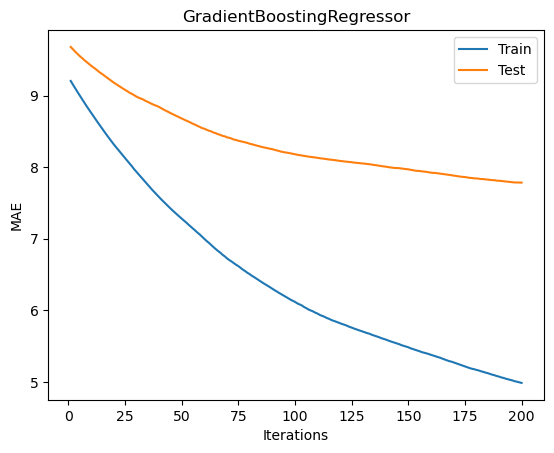

In [114]:
from sklearn.metrics import mean_squared_error

iterations_gbr_train = list(best_gbr.staged_predict(X_train))
iterations_gbr_test = list(best_gbr.staged_predict(X_test))

mae_gbr_train = [mean_absolute_error(y_train,i) for i in iterations_gbr_train]
mae_gbr_test = [mean_absolute_error(y_test,i) for i in iterations_gbr_test]


plt.plot(range(1, 201), mae_gbr_train, label='Train')
plt.plot(range(1, 201), mae_gbr_test, label='Test')

plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('GradientBoostingRegressor')
plt.legend()
plt.show()

#### Обучение на оригинальных данных

In [86]:
tknzr = TweetTokenizer()
original_document = []

for document in data['посты']:
    document = tknzr.tokenize(document)
    document = [word.lower() for word in document]
    original_document.append(document)

In [87]:
original_text = [' '.join(i) for i in original_document]
original_text

['уважаемые петербуржцы ! в официальной группе комитета по транспорту участились случаи , когда на комментарии отвечают сторонние пользователи от имени групп , которые могут ассоциироваться с комитетом по транспорту . злоумышленники дают ложную информацию о деятельности комитета , маршрутах общественного транспорта и прочем , чем вводят вас в заблуждение . напоминаем , что официальные комментарии от имени комитета по транспорту , спб гку « организатор перевозок » и правительства санкт-петербурга пишутся только под шапкой « комитет по транспорту » ( с галочкой верификации ) . остальные посты от людей или сообществ , маскирующихся под комитет по транспорту или ассоциирующихся с представителями комитета по транспорту , являются частным мнением сторонних людей и не имеют отношения к комитету по транспорту . ❗ ️просим проявлять бдительность , не реагировать на такие посты и не вступать в переписку ! ‼ ️напоминаем правила группы : мы просим не использовать оскорбления и относиться уважительн

In [88]:
#добавление в датафрейм обработанного текста 
data['original_text'] = original_text

In [89]:
vectorizer = TfidfVectorizer(min_df = 10)
vectors = vectorizer.fit_transform(original_text)
fichi = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
fichi

00  000       01        10       100  1000        11  110       115  \
0     0.0  0.0  0.00000  0.000000  0.000000   0.0  0.000000  0.0  0.000000   
1     0.0  0.0  0.00000  0.084080  0.050990   0.0  0.050465  0.0  0.000000   
2     0.0  0.0  0.00000  0.065008  0.078847   0.0  0.000000  0.0  0.000000   
3     0.0  0.0  0.00000  0.000000  0.000000   0.0  0.000000  0.0  0.096457   
4     0.0  0.0  0.00000  0.000000  0.000000   0.0  0.000000  0.0  0.000000   
...   ...  ...      ...       ...       ...   ...       ...  ...       ...   
1193  0.0  0.0  0.00000  0.000000  0.000000   0.0  0.000000  0.0  0.000000   
1194  0.0  0.0  0.07432  0.000000  0.000000   0.0  0.051998  0.0  0.000000   
1195  0.0  0.0  0.00000  0.000000  0.000000   0.0  0.000000  0.0  0.000000   
1196  0.0  0.0  0.00000  0.000000  0.000000   0.0  0.000000  0.0  0.000000   
1197  0.0  0.0  0.00000  0.000000  0.000000   0.0  0.000000  0.0  0.000000   

           116  ...     этому  этот       эту    южного  юрлицо  является  \
0     0.000000  ...  0.000000   0.0  0.000000  0.000000     0.0       0.0   
1     0.000000  ...  0.000000   0.0  0.000000  0.074945     0.0       0.0   
2     0.000000  ...  0.000000   0.0  0.000000  0.000000     0.0       0.0   
3     0.096457  ...  0.000000   0.0  0.000000  0.000000     0.0       0.0   
4     0.000000  ...  0.000000   0.0  0.000000  0.000000     0.0       0.0   
...        ...  ...       ...   ...       ...       ...     ...       ...   
1193  0.000000  ...  0.000000   0.0  0.000000  0.000000     0.0       0.0   
1194  0.000000  ...  0.069869   0.0  0.141038  0.000000     0.0       0.0   
1195  0.000000  ...  0.000000   0.0  0.000000  0.000000     0.0       0.0   
1196  0.000000  ...  0.000000   0.0  0.000000  0.000000     0.0       0.0   
1197  0.000000  ...  0.000000   0.0  0.000000  0.000000     0.0       0.0   

      являются  январе   января    яндекс  
0     0.120786     0.0  0.00000  0.000000  
1     0.000000     0.0  0.00000  0.073004  
2     0.000000     0.0  0.00000  0.000000  
3     0.000000     0.0  0.00000  0.000000  
4     0.101861     0.0  0.00000  0.000000  
...        ...     ...      ...       ...  
1193  0.000000     0.0  0.00000  0.000000  
1194  0.000000     0.0  0.05706  0.000000  
1195  0.000000     0.0  0.00000  0.000000  
1196  0.000000     0.0  0.00000  0.000000  
1197  0.000000     0.0  0.00000  0.000000  

[1198 rows x 2167 columns]

In [90]:
fichi['лайки'] = data['лайки']
y = data['комментарии']

In [91]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
fichi, y, test_size=0.3, random_state=42)

In [87]:
grid_search_cv_reg=GridSearchCV(regressor, parametrs, cv=5)#добавляем еще кросс-валидацию с пятью фолдами
grid_search_cv_reg.fit(X_train_orig, y_train_orig)
best_reg_original = grid_search_cv_reg.best_estimator_

In [97]:
parametrs={'n_estimators': [100],'min_samples_split':[10],
           'min_samples_leaf':[10],'learning_rate':[0.01],'max_depth':[10]}

gbr = GradientBoostingRegressor()

In [98]:
grid_search_cv_gbr=GridSearchCV(gbr, parametrs, cv=5)#добавляем еще кросс-валидацию с пятью фолдами
grid_search_cv_gbr.fit(X_train_orig, y_train_orig)
best_gbr_orig = grid_search_cv_gbr.best_estimator_

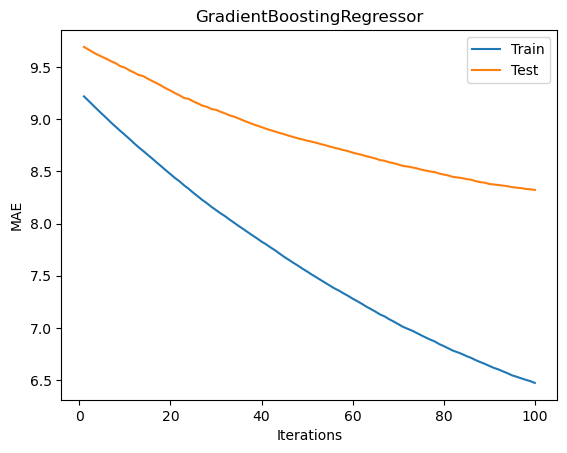

In [99]:
from sklearn.metrics import mean_squared_error

iterations_gbr_train = list(best_gbr_orig.staged_predict(X_train_orig))
iterations_gbr_test = list(best_gbr_orig.staged_predict(X_test_orig))

mae_gbr_train = [mean_absolute_error(y_train_orig,i) for i in iterations_gbr_train]
mae_gbr_test = [mean_absolute_error(y_test_orig,i) for i in iterations_gbr_test]


plt.plot(range(1, 101), mae_gbr_train, label='Train')
plt.plot(range(1, 101), mae_gbr_test, label='Test')

plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('GradientBoostingRegressor')
plt.legend()
plt.show()

#### Метрики на обработанных данных

#### На тренировочных данных RandomForestRegressor

In [79]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f"MSE = {mean_squared_error(y_train,best_reg.predict(X_train))}")
print(f"MAE = {mean_absolute_error(y_train,best_reg.predict(X_train))}")

MSE = 78.7850401500651
MAE = 5.939264784849223


#### На тренировочных данных GradientBoostingRegressor

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f"MSE = {mean_squared_error(y_train,best_gbr.predict(X_train))}")
print(f"MAE = {mean_absolute_error(y_train,best_gbr.predict(X_train))}")

MSE = 53.005732243500546
MAE = 4.984340944414204


#### На тестовых данных  RandomForestRegressor

In [80]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f"MSE = {mean_squared_error(y_test,best_reg.predict(X_test))}")
print(f"MAE = {mean_absolute_error(y_test,best_reg.predict(X_test))}")

MSE = 129.90256766702086
MAE = 7.804375224857952


#### На тестовых данных GradientBoostingRegressor

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f"MSE = {mean_squared_error(y_test,best_gbr.predict(X_test))}")
print(f"MAE = {mean_absolute_error(y_test,best_gbr.predict(X_test))}")

MSE = 128.35088117977332
MAE = 7.784803471199065


#### Метрики на оригинальных данных

#### На тренировочных данных RandomForestRegressor

In [88]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f"MSE = {mean_squared_error(y_train_orig,best_reg_original.predict(X_train_orig))}")
print(f"MAE = {mean_absolute_error(y_train_orig,best_reg_original.predict(X_train_orig))}")

MSE = 83.63713807627092
MAE = 6.199575058958052


#### На тестовых данных GradientBoostingRegressor

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f"MSE = {mean_squared_error(y_train_orig,best_gbr_orig.predict(X_train_orig))}")
print(f"MAE = {mean_absolute_error(y_train_orig,best_gbr_orig.predict(X_train_orig))}")

MSE = 84.70984263741175
MAE = 6.473673056646951


#### На тестовых данных RandomForestRegressor

In [89]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f"MSE = {mean_squared_error(y_test_orig,best_reg_original.predict(X_test_orig))}")
print(f"MAE = {mean_absolute_error(y_test_orig,best_reg_original.predict(X_test_orig))}")

MSE = 138.83069638688195
MAE = 8.033825712225308


#### На тестовых данных GradientBoostingRegressor

In [104]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f"MSE = {mean_squared_error(y_test_orig,best_gbr_orig.predict(X_test_orig))}")
print(f"MAE = {mean_absolute_error(y_test_orig,best_gbr_orig.predict(X_test_orig))}")

MSE = 143.41718312558137
MAE = 8.321515002551086


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

data = pd.read_csv('submission.csv') 
sample_text = data['посты']
sample_text = sample_text.astype('str')
maxWordsCount = 5 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff0123456789', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(sample_text.tolist())

In [27]:
stop_words = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()
lemmatizer = WordNetLemmatizer()

token_text = list(tokenizer.word_index.keys())
token_text_ready = []

for document in token_text:
    if document not in stop_words:
        document = lemmatizer.lemmatize(document)
        document = morph.normal_forms(document)
        token_text_ready.append(document[0])
        
token_text_ready

       


['unknown',
 'rusauto',
 'год',
 'метро',
 'также',
 '№',
 'это',
 'быть',
 'год',
 'd',
 'фото',
 'россия',
 'транспорт',
 'движение',
 'станция',
 'автомобиль',
 'lada',
 'ул',
 'работа',
 'время',
 'м',
 'рубль',
 'петербург',
 'сегодня',
 'http',
 'рф',
 'пассажир',
 'автобус',
 'транспорт',
 'л',
 'производство',
 'маршрут',
 'производство',
 'завод',
 'напомнить',
 'мцд',
 'го',
 'км',
 'минута',
 'тысяча',
 'санкт',
 'который',
 'год',
 'ru',
 'машина',
 'автобус',
 'март',
 'петербург',
 'модель',
 'машина',
 'компания',
 'линия',
 'пресс',
 'renault',
 'новый',
 'москва',
 'автоваз',
 'рамка',
 'комитет',
 'который',
 'пр',
 'маршрут',
 'город',
 'новый',
 'движение',
 'завод',
 'новый',
 'газ',
 'февраль',
 'транспортный',
 'полностью',
 'кроме',
 'парковка',
 'связь',
 'год',
 'b',
 'млн',
 'компания',
 'маршрут',
 'район',
 'человек',
 'первый',
 '📌',
 'маршрут',
 'выпуск',
 'пока',
 'бкл',
 'число',
 'машина',
 'состав',
 'новый',
 'ранее',
 'мм',
 'планироваться',
 'далее

In [30]:
matrix_words = tokenizer.texts_to_matrix(token_text_ready, mode='tfidf')

In [33]:
len(matrix_words[0])

5